In [1]:
# Dependencies
import cv2
import json
import lpips
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F

import datapipe
from basicsr.data import build_dataloader, build_dataset
from basicsr.data.degradations import add_jpg_compression
from basicsr.metrics import calculate_psnr, calculate_ssim
from basicsr.utils import FileClient, imfrombytes, img2tensor, tensor2img, scandir

print(torch.version.cuda)            # e.g., '11.7'
print(torch.cuda.is_available())     # True
print(torch.cuda.get_device_name(0)) # 'NVIDIA A40'

/rds/general/user/aem21/home/miniforge3/envs/indigo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


None
False


AssertionError: Torch not compiled with CUDA enabled

# Compression Pipeline

The existing INDIGO+ model has a forward transform that downsamples the input image and a backward transform that upsamples the image. In a naive scheme where we simply apply INDIGO after JPEG encoding-decoding, the decoded JPEG image must be artificially downsampled to be used in the backward transform. This puts the INDIGO-enhanced scheme at a disadvantage as must work with less information, essentially capping the maximum RD performance at sub-baseline.

The goal of this section of the project is to generate a compression pipeline that has better rate-distortion performance than its baseline system (e.g. JPEG). We exploit the fact that the INN forward process learns a downsampling+compression degradation, meaning that we can apply downsampling prior to our chosen compression encoder in the sender side of the compression scheme. Through downsampling, we achieve a much lower bpp representation for transmission, which JPEG by itself will struggle to match with the same distortion level.

![Alt Text](figures/encoding_decoding_pipeline.png)

## Preparing Test Set

The test set is prepped by saving a 100 downsampled and compressed images that the inference script will restore. The dataloader carries out the role of the adapted encoder and JPEG decoder, which we hope to develop into a functions for a INDIGO compression class. The directory containing the degraded images also contains a json file that stores the size of their JPEG encoding vector.

In [3]:
%run inn/prep_test.py

AssertionError: An object named 'FFHQJPEGDataset' was already registered in 'dataset' registry!

In [4]:
with open("testdata/jpeg_qf10/69900.jpg", "rb") as f:
    jpeg_bytes = f.read()

print(len(jpeg_bytes))

FileNotFoundError: [Errno 2] No such file or directory: 'testdata/jpeg_qf10/69900.jpg'

## Inference

For inference, we can use the same inference script as before. The sampler has been adapted to accept smaller input images.

In [5]:
%run inference_compression.py \
    -i testdata/down_jpeg_qf0 -o results/down_jpeg_qf0 --task restoration \
    --eta 0.5 --aligned  --use_fp16 \
    --config_indigo configs/sample/indigo_syn_jpeg_qf0.yaml

KeyboardInterrupt: 

## Data Processing Tools

In [3]:
def calculate_bpp(shape, encsize=None, path=None):
    if (encsize is None):
        encsize = os.stat(path).st_size
    
    return encsize*8 / (shape[0]*shape[1]) # assumes HWC

def calculate_psnr_alt(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * (np.log10(abs(max_value) / (np.sqrt(mse)))).item()

def calculate_mse(img1, img2):
    return (np.mean((img1 - img2) ** 2)).item()

def calculate_rmse(img1, img2):
    return (np.sqrt(calculate_mse(img1, img2))).item()

results = dict()

In [4]:
def result_analysis(test_set, result_set, qf_range, desc, lpips_fn):
    file_client = FileClient('disk')
    gt_folder = 'datasets/ffhq/test'
    
    results = dict()
    results['desc'] = desc
    print(results['desc'])

    lpips_ = []
    psnr = []
    bpp = []

    for factor in qf_range:
        with open(f'testdata/{test_set}jpeg_qf{factor}/encsizes.json', "r") as f:
             encsizes = json.load(f)
    
        res_folder = f'results/jpeg_pipeline/{result_set}/jpeg_qf{factor}/restored_faces'
        paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
        lpips_.append(0)
        psnr.append(0)
        bpp.append(0)
        res_rmse = 0
        res_max = 0
        hq_max = 0
        for path in paths:
            img_bytes = file_client.get(path, 'res')
            img_res = imfrombytes(img_bytes, float32=True)
    
            img_name = os.path.splitext(os.path.basename(path))[0]
            gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
            img_bytes = file_client.get(gt_path, 'gt')
            img_gt = imfrombytes(img_bytes, float32=True)

            # generate lq image
            # downsample
            h, w = img_gt.shape[0:2]
            img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
            img_hq = np.clip(img_hq,0,1)

            # Calculate LPIPS
            img_hq, img_res = img2tensor([img_hq, img_res], bgr2rgb=False, float32=True)
            img_hq = img_hq * 2 - 1
            img_res = img_res * 2 - 1
            # print(f'img_hq is {type(img_hq)}, MAX {img_hq.max()}, MIN {img_hq.min()}')
            lpips_[-1] += loss_fn_alex(img_hq, img_res).item()
            img_hq = img_hq / 2 + 0.5
            img_res = img_res / 2 + 0.5
            img_hq, img_res = tensor2img([img_hq, img_res])
        
            # Calculate metrics
            psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
            bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
            res_rmse += calculate_rmse(img_hq, img_res)
        
            # Record max
            res_max += int(img_res.max())
            hq_max += int(img_hq.max())

        lpips_[-1] = lpips_[-1] / len(paths)
        bpp[-1] = bpp[-1] / len(paths)
        psnr[-1] = psnr[-1] / len(paths)
        res_rmse = res_rmse / len(paths)
        res_max = res_max / len(paths)
        hq_max = hq_max / len(paths)
    
        print(f'JPEG QF{factor} restoration - BPP {bpp[-1]} PSNR {psnr[-1]} LPIPS {lpips_[-1]} RMSE {res_rmse}')

    results['lpips'] = lpips_
    results['psnr'] = psnr
    results['bpp'] = bpp

    return results

## Scheme 0: Classic JPEG

In [5]:
gt_folder = 'datasets/ffhq/test'
file_client = FileClient('disk')
loss_fn_alex = lpips.LPIPS(net='alex')

tmp = dict()
tmp['desc'] = 'Scheme 0: JPEG ENC => JPEG DEC'

qf = list(range(0, 100, 10))
scale = 2

print(tmp['desc'])

lpips_ = []
psnr = []
bpp = []

for factor in qf:
    paths = [os.path.join(gt_folder, v) for v in list(scandir(gt_folder))]
    
    lpips_.append(0)
    psnr.append(0)
    bpp.append(0)
    
    for gt_path in paths:
        # Load gt images. Dimension order: HWC; channel order: BGR;
        # image range: [0, 1], float32.
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)
        
        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        # add JPEG compression
        img_lq, encsize = add_jpg_compression(img_hq, quality=factor, size = True)
        
        # BGR to RGB, HWC to CHW, numpy to tensor
        img_hq, img_lq = img2tensor([img_hq, img_lq], bgr2rgb=True, float32=True)
        img_lq = torch.clamp((img_lq * 255.0).round(), 0, 255) / 255
        
        # calculate LPIPS
        img_hq = img_hq * 2 - 1
        img_lq = img_lq * 2 - 1
        lpips_[-1] += loss_fn_alex(img_hq, img_lq).item()
        img_hq = img_hq / 2 + 0.5
        img_lq = img_lq / 2 + 0.5
        
        img_hq, img_lq = tensor2img([img_hq, img_lq])
        
        # Calculate PSNR
        psnr[-1] += calculate_psnr_alt(img_hq, img_lq, img_hq.max())
        
        # Calculate BPP
        # Function works with HWC dimension ordering
        bpp[-1] += calculate_bpp(img_lq.shape, encsize=encsize.item())
        
    lpips_[-1] = lpips_[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    bpp[-1] = bpp[-1] / len(paths)
    
    print(f"JPEG qf{factor} compression - PSNR {psnr[-1]} LPIPS {lpips_[-1]} BPP {bpp[-1]}")

tmp['lpips'] = lpips_
tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['0'] = tmp

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/rds/general/user/aem21/home/miniforge3/envs/indigo/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/rds/general/user/aem21/home/miniforge3/envs/indigo/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /rds/general/user/aem21/home/miniforge3/envs/indigo/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Scheme 0: JPEG ENC => JPEG DEC


[ WARN:0@305.464] global loadsave.cpp:1329 imencode Unsupported depth image for selected encoder is fallbacked to CV_8U.


JPEG qf0 compression - PSNR 28.9297966367971 LPIPS 0.6226144304871559 BPP 0.16686798095703126
JPEG qf10 compression - PSNR 31.29620353454879 LPIPS 0.3352617488801479 BPP 0.265042724609375
JPEG qf20 compression - PSNR 32.963303186457985 LPIPS 0.1907637046277523 BPP 0.38778472900390626
JPEG qf30 compression - PSNR 33.81205479513795 LPIPS 0.13424982652068138 BPP 0.49850311279296877
JPEG qf40 compression - PSNR 34.352502087660774 LPIPS 0.10554397616535426 BPP 0.595843505859375
JPEG qf50 compression - PSNR 34.776552094981774 LPIPS 0.0865224264934659 BPP 0.6916702270507813
JPEG qf60 compression - PSNR 35.172445318996736 LPIPS 0.07055502850562334 BPP 0.7974566650390625
JPEG qf70 compression - PSNR 35.72118207713154 LPIPS 0.052449071872979404 BPP 0.9651593017578125
JPEG qf80 compression - PSNR 36.55123096023724 LPIPS 0.03326073265634477 BPP 1.245867919921875
JPEG qf90 compression - PSNR 38.35282321870881 LPIPS 0.013870990397408604 BPP 1.931898193359375


In [1]:
# Plot results
qf = range(0,100,10)
fig, ax = plt.subplots(figsize=[5,4])

ax.plot(qf,results['0']['psnr'], label='JPEG')
ax.set_xlabel('Quality Factor')
ax.set_ylabel('Reconstruction PSNR (dB)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.minorticks_on()
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.legend()
ax.set_xlim(0,90)

fig.show()   

NameError: name 'plt' is not defined

## Scheme 1: INDIGO-enhanced JPEG (w/o downsampling)

In [89]:
tmp = dict()
tmp['desc'] = 'Scheme 1: JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for quality in qf:
    with open(f'testdata/jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/default/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        img_hq = np.clip(img_hq,0,1)
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['1'] = tmp

Scheme 1: JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)
JPEG QF0 restoration - BPP 0.16686798095703126 	 PSNR 22.13178902864456 	 RMSE 0.07852164470447132
JPEG QF10 restoration - BPP 0.265042724609375 	 PSNR 27.1874675989151 	 RMSE 0.04464915238472697
JPEG QF20 restoration - BPP 0.38778472900390626 	 PSNR 27.848362922668457 	 RMSE 0.041522958023217066
JPEG QF30 restoration - BPP 0.49850311279296877 	 PSNR 28.394711112976076 	 RMSE 0.03907562028156871
JPEG QF40 restoration - BPP 0.595843505859375 	 PSNR 28.68515465259552 	 RMSE 0.0378281715158951
JPEG QF50 restoration - BPP 0.6916702270507813 	 PSNR 28.849946999549864 	 RMSE 0.03713451743649754
JPEG QF60 restoration - BPP 0.7974566650390625 	 PSNR 29.00022702217102 	 RMSE 0.036498230729611274
JPEG QF70 restoration - BPP 0.9651593017578125 	 PSNR 29.12205617427826 	 RMSE 0.036007695639049465
JPEG QF80 restoration - BPP 1.245867919921875 	 PSNR 29.208328819274904 	 RMSE 0.03567018287273563
JPEG QF90 restor

## Scheme 1.1: Larger training set

In [ ]:
tmp = dict()
tmp['desc'] = 'Scheme 1.1: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for f in qf:
    with open(f'testdata/jpeg_qf{f}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/default_large/jpeg_qf{f}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        img_hq = np.clip(img_hq,0,1)
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['1.1'] = tmp

## Scheme 1.2: Larger training set and perceptual loss

In [9]:
tmp = dict()
tmp['desc'] = 'Scheme 1.2: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE+percep loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for quality in qf:
    with open(f'testdata/jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/default_large_percep/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        img_hq = np.clip(img_hq,0,1)
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['1.2'] = tmp

Scheme 1.2: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE+percep loss)
JPEG QF0 restoration - BPP 0.16686798095703126 	 PSNR 22.955415153503417 	 RMSE 0.07388045830031581
JPEG QF10 restoration - BPP 0.265042724609375 	 PSNR 26.451067757606506 	 RMSE 0.050018934202909725
JPEG QF20 restoration - BPP 0.38778472900390626 	 PSNR 27.25498147010803 	 RMSE 0.04582299735768866
JPEG QF30 restoration - BPP 0.49850311279296877 	 PSNR 27.805256915092468 	 RMSE 0.04313581992040822
JPEG QF40 restoration - BPP 0.595843505859375 	 PSNR 28.116161274909974 	 RMSE 0.04168100531352558
JPEG QF50 restoration - BPP 0.6916702270507813 	 PSNR 28.286946177482605 	 RMSE 0.04089963209053944
JPEG QF60 restoration - BPP 0.7974566650390625 	 PSNR 28.413246512413025 	 RMSE 0.040319485405090394
JPEG QF70 restoration - BPP 0.9651593017578125 	 PSNR 28.57795593738556 	 RMSE 0.039570574525263635
JPEG QF80 restoration - BPP 1.245867919921875 	 PSNR 28.77566239833832 	 RMSE 0.038694233743199705
JP

## ALL SCHEME 1

In [6]:
loss_fn_alex = lpips.LPIPS(net='alex')
qf_range = range(0, 100, 10)

desc = 'Scheme 1: JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)'
results['1.0'] = result_analysis('','default', qf_range, desc, loss_fn_alex)

desc = 'Scheme 1.1: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)'
results['1.1'] = result_analysis('','default_large', qf_range, desc, loss_fn_alex)

desc = 'Scheme 1.2: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE+percep loss)'
results['1.2'] = result_analysis('','default_large_percep', qf_range, desc, loss_fn_alex)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/general/user/aem21/home/miniforge3/envs/indigo_v2/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
Scheme 1: JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)
JPEG QF0 restoration - BPP 0.16686798095703126 PSNR 28.999333491208255 LPIPS 0.36585125848650935 RMSE 9.046024623444167
JPEG QF10 restoration - BPP 0.265042724609375 PSNR 31.75241656924478 LPIPS 0.23574359178543092 RMSE 6.604877703143015
JPEG QF20 restoration - BPP 0.38778472900390626 PSNR 32.43091567313452 LPIPS 0.20021820634603502 RMSE 6.117931850002499
JPEG QF30 restoration - BPP 0.49850311279296877 PSNR 32.786198650960685 LPIPS 0.20519427418708802 RMSE 5.878456744521669
JPEG QF40 restoration - BPP 0.595843505859375 PSNR 32.97413881362129 LPIPS 0.21409164175391196 RMSE 5.75545762554598
JPEG QF50 restoration - BPP 0.6916702270507813 PSNR 33.08341966618134 LPIPS 0.22235700935125352 RMSE 5.68507545

## Scheme 2: INDIGO-enhanced JPEG (w/ downsampling)

In [10]:
tmp = dict()
tmp['desc'] = 'Scheme 2: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for quality in qf:
    with open(f'testdata/down_jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/down/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        img_hq = np.clip(img_hq,0,1)
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['2'] = tmp

Scheme 2: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)
JPEG QF0 restoration - BPP 0.0308026123046875 	 PSNR 19.390556895732878 	 RMSE 0.1112201421018781
JPEG QF10 restoration - BPP 0.0444940185546875 	 PSNR 24.854798948764802 	 RMSE 0.06018413431377927
JPEG QF20 restoration - BPP 0.05915740966796875 	 PSNR 26.026478171348572 	 RMSE 0.052880290541506184
JPEG QF30 restoration - BPP 0.0718359375 	 PSNR 26.464679980278014 	 RMSE 0.05041859241009223
JPEG QF40 restoration - BPP 0.08274200439453125 	 PSNR 26.705528950691225 	 RMSE 0.04912317290530135
JPEG QF50 restoration - BPP 0.09317657470703125 	 PSNR 26.877191710472108 	 RMSE 0.048217866408876875
JPEG QF60 restoration - BPP 0.10449310302734376 	 PSNR 27.0245423078537 	 RMSE 0.04742656833498776
JPEG QF70 restoration - BPP 0.12196044921875 	 PSNR 27.205939602851867 	 RMSE 0.04647234812933848
JPEG QF80 restoration - BPP 0.15024017333984374 	 PSNR 27.433603644371033 	 RMSE 0.045272716431679995
JPEG

The results above suggest that the INN is not learning the JPEG degradation process effectively. Furthermore, the downsampling scheme underperforms the naive scheme, meaning that providing a larger input for the initial prediction network is more impactful than the INN.

Next Steps:

* Larger training and validation sets
* Use perceptual loss such as LPIPS

## Scheme 2.1: Larger Training Set

In [12]:
# Profile our models
import json

tmp = dict()
tmp['desc'] = 'Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)'
print(tmp['desc'])

qf = range(10,100,10)
psnr = []
bpp = []
for quality in qf:
    with open(f'testdata/down_jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/down_large/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        img_hq = np.clip(img_hq,0,1)
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['2.1'] = tmp

Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)
JPEG QF10 restoration - BPP 0.0444940185546875 	 PSNR 24.772856378555296 	 RMSE 0.0607057316417838
JPEG QF20 restoration - BPP 0.05915740966796875 	 PSNR 26.018643152713775 	 RMSE 0.05294607766265437
JPEG QF30 restoration - BPP 0.0718359375 	 PSNR 26.451445388793946 	 RMSE 0.050515339239282794
JPEG QF40 restoration - BPP 0.08274200439453125 	 PSNR 26.70150680541992 	 RMSE 0.0491687156347743
JPEG QF50 restoration - BPP 0.09317657470703125 	 PSNR 26.879808378219604 	 RMSE 0.04821773869095497
JPEG QF60 restoration - BPP 0.10449310302734376 	 PSNR 27.022880291938783 	 RMSE 0.0474571100101557
JPEG QF70 restoration - BPP 0.12196044921875 	 PSNR 27.203818988800048 	 RMSE 0.04649624608481043
JPEG QF80 restoration - BPP 0.15024017333984374 	 PSNR 27.446991634368896 	 RMSE 0.045211768464392385
JPEG QF90 restoration - BPP 0.21333892822265624 	 PSNR 27.752013206481934 	 RMSE 0.043711295868895036


## Scheme 2.2: Introducing Perceptual Loss

In [13]:
tmp = dict()
tmp['desc'] = 'Scheme 2.2: down x4 => JPEG ENC => JPEG DEC => INDIGO (percep loss + larger training set)'
print(tmp['desc'])

qf = range(0, 100, 10)
psnr = []
bpp = []

for quality in qf:
    with open(f'testdata/down_jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/down_large_percep/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} -  \t BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['2.2'] = tmp

Scheme 2.2: down x4 => JPEG ENC => JPEG DEC => INDIGO (percep loss + larger training set)
JPEG QF0 -  	 BPP 0.0308026123046875 	 PSNR 19.92735723257065 	 RMSE 0.10461732492484793
JPEG QF10 -  	 BPP 0.0444940185546875 	 PSNR 24.74678100347519 	 RMSE 0.06079709072409095
JPEG QF20 -  	 BPP 0.05915740966796875 	 PSNR 25.891638886928558 	 RMSE 0.053581587028045934
JPEG QF30 -  	 BPP 0.0718359375 	 PSNR 26.474509739875792 	 RMSE 0.05026674427917654
JPEG QF40 -  	 BPP 0.08274200439453125 	 PSNR 26.800284790992738 	 RMSE 0.048506560125274524
JPEG QF50 -  	 BPP 0.09317657470703125 	 PSNR 27.008118772506712 	 RMSE 0.04742123261951791
JPEG QF60 -  	 BPP 0.10449310302734376 	 PSNR 27.172796654701234 	 RMSE 0.0465637300313537
JPEG QF70 -  	 BPP 0.12196044921875 	 PSNR 27.367343044281007 	 RMSE 0.04557205445650517
JPEG QF80 -  	 BPP 0.15024017333984374 	 PSNR 27.619076442718505 	 RMSE 0.04429509437414134
JPEG QF90 -  	 BPP 0.21333892822265624 	 PSNR 28.02461862564087 	 RMSE 0.042349106095222154


In [ ]:
# Plot results
fig, ax = plt.subplots()
ax.plot(bpp, psnr, label='JPEG')
ax.plot(res_bpp,res_psnr, color='r', label='large train set + percep')
ax.set_title('Rate-Distortion Performance')
ax.set_xlabel('bpp')
ax.set_ylabel('PSNR ($dB$)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.legend()
fig.show()   

## ALL SCHEME 2

In [7]:
loss_fn_alex = lpips.LPIPS(net='alex')

desc = 'Scheme 2: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)'
results['2.0'] = result_analysis('down_','down',desc, loss_fn_alex)

desc = 'Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)'
results['2.1'] = result_analysis('down_','down_large',desc, loss_fn_alex)

desc = 'Scheme 2.2: down x4 => JPEG ENC => JPEG DEC => INDIGO (percep loss + larger training set)'
results['2.2'] = result_analysis('down_','down_large_percep',desc, loss_fn_alex)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/general/user/aem21/home/miniforge3/envs/indigo_v2/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
Scheme 2: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)
JPEG QF0 restoration - BPP 0.0308026123046875 PSNR 28.590227090522685 LPIPS 0.5535693269968033 RMSE 9.48095566971207
JPEG QF10 restoration - BPP 0.0444940185546875 PSNR 30.464527501189856 LPIPS 0.3261268226802349 RMSE 7.650490260249179
JPEG QF20 restoration - BPP 0.05915740966796875 PSNR 31.34386349797198 LPIPS 0.25204340562224387 RMSE 6.92130772320265
JPEG QF30 restoration - BPP 0.0718359375 PSNR 31.72244824512368 LPIPS 0.23584699556231498 RMSE 6.631153798472894
JPEG QF40 restoration - BPP 0.08274200439453125 PSNR 31.93732285285651 LPIPS 0.2257756121456623 RMSE 6.47272233998357
JPEG QF50 restoration - BPP 0.09317657470703125 PSNR 32.078964477022964 LPIPS 0.22011594146490096 RMSE 6.36977

## Scheme 3: JPEG (w/ downsampling & upsampling)

In [9]:
tmp = dict()
tmp['desc'] = 'Scheme 3: down x4 => JPEG ENC => JPEG DEC => up x4'
print(tmp['desc'])

lpips_ = []
psnr = []
bpp = []

dataset_opt = {
    'name': 'FFHQJPEGTest',
    'type': 'FFHQJPEGDataset',
    'phase': 'test',
    'gt_size': 512,
    'scale': 4,
    'encsize': True,
    'qf': 0,
    'dataroot_gt': 'datasets/ffhq/test',
    'io_backend':
        {'type': 'disk'} 
}

qf = range(0, 100, 10)
for factor in qf:
    dataset_opt['qf'] = factor
    test_set = build_dataset(dataset_opt)
    test_loader = build_dataloader(
                test_set,
                dataset_opt,
                num_gpu=1,
                dist=False,
                sampler=None,
                seed=0)

    lpips_.append(0)
    psnr.append(0)
    bpp.append(0)
    for idx, val_data in enumerate(test_loader):
        img_hq = val_data['gt'] # 512x512
        img_lq = val_data['lq'] # 128x128
        encsize = val_data['encsize'].item()

        img_lq = F.interpolate(img_lq, 512, mode='bicubic', antialias=True)
        img_lq = torch.clamp((img_lq * 255.0).round(), 0, 255) / 255.
        # print(img_lq.max())
        # print(img_hq.max())

        # Calculate LPIPS
        img_hq = img_hq * 2 - 1
        img_lq = img_lq * 2 - 1
        # print(f'img_hq is {type(img_hq)}, MAX {img_hq.max()}, MIN {img_hq.min()}')
        lpips_[-1] += loss_fn_alex(img_hq, img_lq).item()
        img_hq = img_hq / 2 + 0.5
        img_lq = img_lq / 2 + 0.5
        img_hq, img_lq = tensor2img([img_hq, img_lq])

        # Calculate PSNR
        psnr[-1] += calculate_psnr_alt(img_hq, img_lq, img_hq.max())
    
        # Calculate BPP
        # Function works with HWC dimension ordering
        bpp[-1] += calculate_bpp(img_lq.shape, encsize=encsize)

    lpips_[-1] = lpips_[-1] / len(test_set)
    psnr[-1] = psnr[-1] / len(test_set)
    bpp[-1] = bpp[-1] / len(test_set)

    print(f"JPEG qf{factor} - PSNR {psnr[-1]} LPIPS {lpips_[-1]} BPP {bpp[-1]}")

tmp['lpips'] = lpips_
tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['3'] = tmp

Scheme 3: down x4 => JPEG ENC => JPEG DEC => up x4
JPEG qf0 - PSNR 28.64533687567799 LPIPS 0.7426343643665314 BPP 0.0308026123046875
JPEG qf10 - PSNR 29.929654475729162 LPIPS 0.6692490565776825 BPP 0.0444940185546875
JPEG qf20 - PSNR 30.72310646408076 LPIPS 0.6059513095021248 BPP 0.05915740966796875
JPEG qf30 - PSNR 31.149437766593692 LPIPS 0.5635453969240188 BPP 0.0718359375
JPEG qf40 - PSNR 31.414946076847382 LPIPS 0.5362592563033104 BPP 0.08274200439453125
JPEG qf50 - PSNR 31.612481615752085 LPIPS 0.5170535850524902 BPP 0.09317657470703125
JPEG qf60 - PSNR 31.783947056700075 LPIPS 0.5001320332288742 BPP 0.10449310302734376
JPEG qf70 - PSNR 31.997702959032473 LPIPS 0.4810380297899246 BPP 0.12196044921875
JPEG qf80 - PSNR 32.27614880312219 LPIPS 0.46028666585683825 BPP 0.15024017333984374
JPEG qf90 - PSNR 32.73112713441064 LPIPS 0.4331630688905716 BPP 0.21333892822265624


## Rate-Distortion Curves

In [5]:
with open('results/rd_performance.json', 'r') as f:
    results = json.load(f)

# print(json.dumps(results, indent=4))

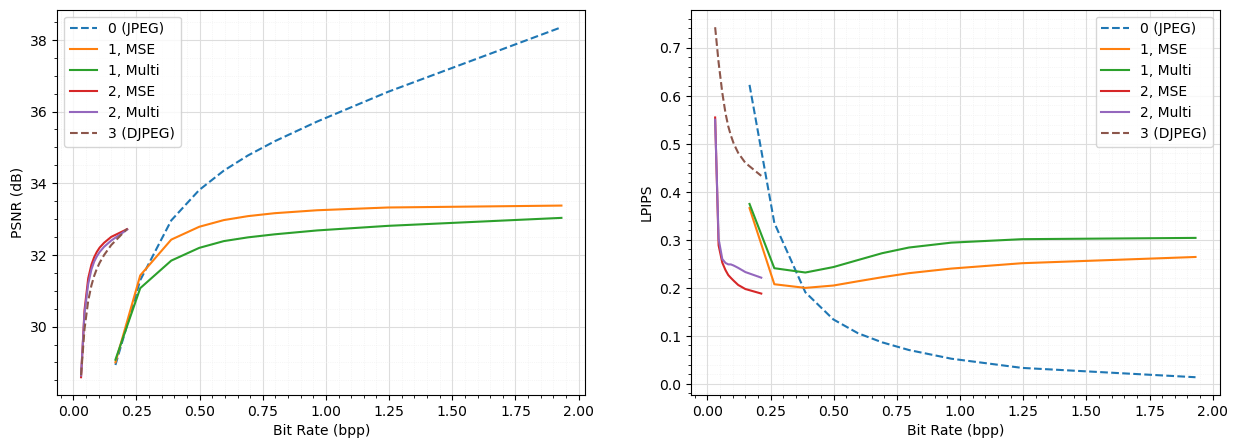

In [59]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=[15,5])
keys = ['0','1.1','1.2','2.1','2.2','3']
# markers = ['x','*','s','x','*','s']
labels = ['0 (JPEG)', '1, MSE', '1, Multi', '2, MSE', '2, Multi', '3 (DJPEG)']
metrics = ['psnr','lpips']
ylabels = ['PSNR (dB)','LPIPS']

for i in range(2):
    for j,key in enumerate(keys):
        style = '--' if (key in ['0','3']) else ''
        axs[i].plot(results[key]['bpp'],results[key][metrics[i]], style, label=labels[j])
    axs[i].set_xlabel('Bit Rate (bpp)')
    axs[i].set_ylabel(ylabels[i])
    axs[i].grid(which='major', color='#DDDDDD', linewidth=0.8)
    axs[i].minorticks_on()
    axs[i].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    axs[i].legend()

fig.show()   

In [60]:
fig.savefig('figures/rd_performance.pdf', dpi=200, bbox_inches='tight')

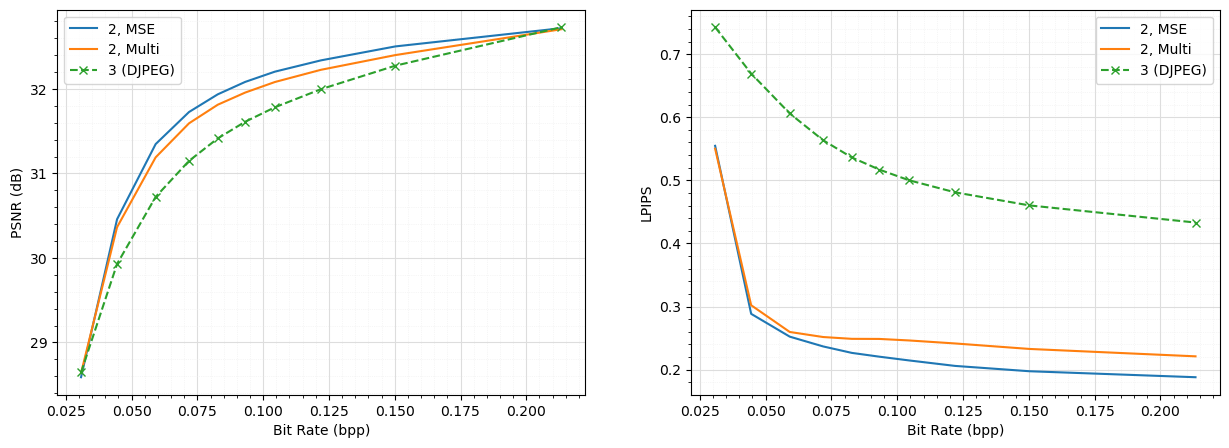

In [72]:
# Plot results
fig, axs = plt.subplots(1,2, figsize=[15,5])
keys = ['2.1','2.2','3']
labels = ['2, MSE', '2, Multi', '3 (DJPEG)']
metrics = ['psnr','lpips']
ylabels = ['PSNR (dB)','LPIPS']

for i in range(2):
    for j,key in enumerate(keys):
        style = '--x' if (key in ['0','3']) else ''
        axs[i].plot(results[key]['bpp'],results[key][metrics[i]], style, label=labels[j])
    axs[i].set_xlabel('Bit Rate (bpp)')
    axs[i].set_ylabel(ylabels[i])
    axs[i].legend()
    axs[i].grid(which='major', color='#DDDDDD', linewidth=0.8)
    axs[i].minorticks_on()
    axs[i].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

fig.show()   

In [64]:
fig.savefig('figures/rd_performance_zoom.pdf', dpi=200, bbox_inches='tight')

## Bjontegaard-Delta Rate

In [46]:
with open('results/rd_performance.json', 'r') as f:
    results = json.load(f)

In [47]:
import bjontegaard as bd

points = [0, 3, 6, 9]

rate_anchor = [results['3']['bpp'][p] for p in points]
psnr_anchor = [results['3']['psnr'][p] for p in points]
rate_test = [results['2.0']['bpp'][p] for p in points]
psnr_test = [results['2.0']['psnr'][p] for p in points]

print(rate_anchor)
print(rate_test)

bd_rate = bd.bd_rate(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')
bd_psnr = bd.bd_psnr(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')

print("Scheme 2 w.r.t. scheme 3")
print(f"BD-Rate: {bd_rate:.4f} %")
print(f"BD-PSNR: {bd_psnr:.4f} dB")

rate_test = [results['2.1']['bpp'][p] for p in points]
psnr_test = [results['2.1']['psnr'][p] for p in points]
bd_rate = bd.bd_rate(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')
bd_psnr = bd.bd_psnr(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')

print("Scheme 2.1 w.r.t. scheme 3")
print(f"BD-Rate: {bd_rate:.4f} %")
print(f"BD-PSNR: {bd_psnr:.4f} dB")

rate_test = [results['2.2']['bpp'][p] for p in points]
psnr_test = [results['2.2']['psnr'][p] for p in points]
bd_rate = bd.bd_rate(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')
bd_psnr = bd.bd_psnr(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')

print("Scheme 2.2 w.r.t. scheme 3")
print(f"BD-Rate: {bd_rate:.4f} %")
print(f"BD-PSNR: {bd_psnr:.4f} dB")

rate_anchor = [results['0']['bpp'][p] for p in points]
psnr_anchor = [results['0']['psnr'][p] for p in points]
rate_test = [results['2.1']['bpp'][p] for p in points]
psnr_test = [results['2.1']['psnr'][p] for p in points]
bd_rate = bd.bd_rate(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')
bd_psnr = bd.bd_psnr(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')

print("Scheme 2.1 w.r.t. scheme 0")
print(f"BD-Rate: {bd_rate:.4f} %")
print(f"BD-PSNR: {bd_psnr:.4f} dB")

[0.0308026123046875, 0.0718359375, 0.10449310302734376, 0.21333892822265624]
[0.0308026123046875, 0.0718359375, 0.10449310302734376, 0.21333892822265624]
Scheme 2 w.r.t. scheme 3
BD-Rate: -17.8708 %
BD-PSNR: 0.3394 dB
Scheme 2.1 w.r.t. scheme 3
BD-Rate: -18.2467 %
BD-PSNR: 0.3400 dB
Scheme 2.2 w.r.t. scheme 3
BD-Rate: -14.7768 %
BD-PSNR: 0.2600 dB
Scheme 2.1 w.r.t. scheme 0
BD-Rate: -77.0208 %
BD-PSNR: 3.0896 dB


/rds/general/user/aem21/home/miniforge3/envs/indigo_v2/lib/python3.12/site-packages/bjontegaard/bjontegaard_delta.py:54: UserWarning: Insufficient curve overlap: '38.81'. Minimum overlap: '75.00'. You can silence this warning by setting `min_overlap=0`
  warnings.warn(
/rds/general/user/aem21/home/miniforge3/envs/indigo_v2/lib/python3.12/site-packages/bjontegaard/bjontegaard_delta.py:54: UserWarning: Insufficient curve overlap: '5.94'. Minimum overlap: '75.00'. You can silence this warning by setting `min_overlap=0`
  warnings.warn(


## Consistency Step Hyperparameters

Extracted from `models/guided_diffusion.py`

```python
            y0_norm = y0 / 2 + 0.5
            cn, dn = self.model_inn.dae_f(x=out["pred_xstart"] / 2 + 0.5, cond=cond)
            x_0_hat01_opt = self.model_inn.dae_b(cn=y0_norm, dn=dn, cond=cond)
            difference_f = y0_norm - cn
            norm_f = th.linalg.norm(difference_f)
            norm_b_fea = iqa_loss(x_0_hat01_opt, (out["pred_xstart"] / 2 + 0.5))


            norm = self.configs_indigo.weight[0] * norm_f +self.configs_indigo.weight[1] * norm_b_fea


            norm_grad = th.autograd.grad(outputs=norm, inputs=img)[0]
            out["sample"] = out["sample"] - norm_grad * self.configs_indigo.scale
            img = out["sample"]
            img = img.detach_()
```

This is the data consistency step in action, where `self.configs_indigo.scale` is the step size parameter that controls how strongly the diffusion process is guided by the INN estimate. The hyperparameter `self.configs_indigo_weight` is an array length 2 which determines the weighting between losses `norm_f` and `norm_b_fea`.

In [33]:
zeta = [0,0.5,1,1.5,2,2.5,3]
qf = range(0,100,10)

loss_fn_alex = lpips.LPIPS(net='alex')

psnr = []
lpips_ = []
for z in zeta:
    psnr.append([])
    lpips_.append([])
    for f in qf:
        res_folder = f'results/jpeg_pipeline/down_large_zeta{round(z*10)}/jpeg_qf{f}/restored_faces'
        paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
        psnr[-1].append(0)
        lpips_[-1].append(0)
        res_rmse = 0
        res_max = 0
        hq_max = 0
        for path in paths:
            img_bytes = file_client.get(path, 'res')
            img_res = imfrombytes(img_bytes, float32=True)
    
            img_name = os.path.splitext(os.path.basename(path))[0]
            gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
            img_bytes = file_client.get(gt_path, 'gt')
            img_gt = imfrombytes(img_bytes, float32=True)

            # generate lq image
            # downsample
            h, w = img_gt.shape[0:2]
            img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
            img_hq = np.clip(img_hq,0,1)

            # Calculate metrics
            psnr[-1][-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
            res_rmse += calculate_rmse(img_hq, img_res)
        
            # Calculate LPIPS
            img_hq, img_res = img2tensor([img_hq, img_res], bgr2rgb=False, float32=True)
            img_hq = img_hq * 2 - 1
            img_res = img_res * 2 - 1
            # print(f'img_hq is {type(img_hq)}, MAX {img_hq.max()}, MIN {img_hq.min()}')
            lpips_[-1][-1] += loss_fn_alex(img_hq, img_res).item()
            img_hq = img_hq / 2 + 0.5
            img_res = img_res / 2 + 0.5
            img_hq, img_res = tensor2img([img_hq, img_res])
            # print(f'img_hq is {type(img_hq)}, MAX {img_hq.max()}, MIN {img_hq.min()}')
            
            # Record max
            res_max += img_res.max()
            hq_max += img_hq.max()

        psnr[-1][-1] = psnr[-1][-1] / len(paths)
        lpips_[-1][-1] = lpips_[-1][-1] / len(paths)
        res_rmse = res_rmse / len(paths)
        res_max = res_max / len(paths)
        hq_max = hq_max / len(paths)
    
        print(f'JPEG QF{f}: PSNR {psnr[-1][-1]} LPIPS {lpips_[-1][-1]} RMSE {res_rmse} RES_MAX {res_max} HQ_MAX {hq_max}')

for i,z in enumerate(zeta):
    plt.plot(qf,psnr[i],label=f'zeta={z}')
plt.xlabel('Quality Factor')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/general/user/aem21/home/miniforge3/envs/indigo_v2/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/var/tmp/pbs.474593.pbs-7/ipykernel_191821/3013712088.py:51: RuntimeWarning: overflow encountered in scalar add
  res_max += img_res.max()
/var/tmp/pbs.474593.pbs-7/ipykernel_191821/3013712088.py:52: RuntimeWarning: overflow encountered in scalar add
  hq_max += img_hq.max()


JPEG QF0: PSNR 19.866503214836122 LPIPS 0.4826069030165672 RMSE 0.10201113220272844 RES_MAX 0.88 HQ_MAX 1.32
JPEG QF10: PSNR 24.06349139213562 LPIPS 0.2827673152089119 RMSE 0.06360174066501818 RES_MAX 1.94 HQ_MAX 1.32
JPEG QF20: PSNR 24.621108686923982 LPIPS 0.25843000307679176 RMSE 0.05971079445381215 RES_MAX 2.5 HQ_MAX 1.32
JPEG QF30: PSNR 24.76226066350937 LPIPS 0.2519578602910042 RMSE 0.0587664329865002 RES_MAX 2.46 HQ_MAX 1.32
JPEG QF40: PSNR 24.82019190788269 LPIPS 0.24851019829511642 RMSE 0.05838225663558119 RES_MAX 0.04 HQ_MAX 1.32
JPEG QF50: PSNR 24.863907051086425 LPIPS 0.24628144428133963 RMSE 0.058087789235861914 RES_MAX 0.25 HQ_MAX 1.32
JPEG QF60: PSNR 24.887320137023927 LPIPS 0.24436842918395996 RMSE 0.0579293185605282 RES_MAX 2.54 HQ_MAX 1.32
JPEG QF70: PSNR 24.916880452632903 LPIPS 0.24319312594830989 RMSE 0.057740712392801444 RES_MAX 0.04 HQ_MAX 1.32
JPEG QF80: PSNR 24.951170349121092 LPIPS 0.24243005208671092 RMSE 0.05751106136372933 RES_MAX 0.12 HQ_MAX 1.32
JPEG QF90

KeyboardInterrupt: 

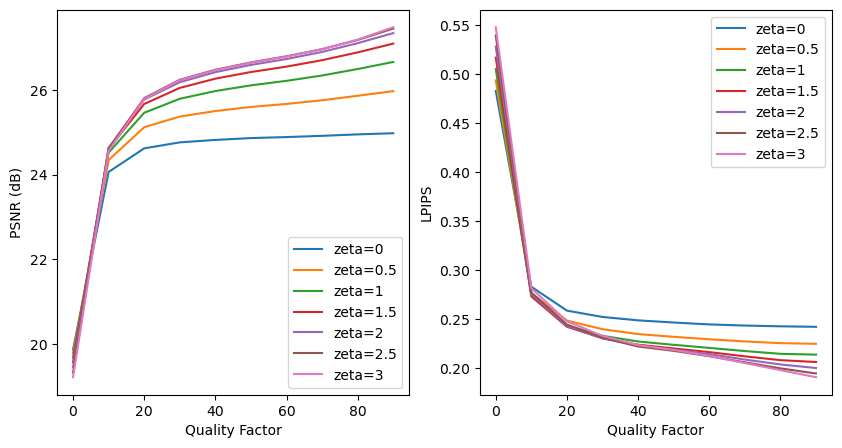

In [27]:
fig, axs = plt.subplots(1,2, figsize=[10,5])

for i,z in enumerate(zeta):
    axs[0].plot(qf,psnr[i],label=f'zeta={z}')
    axs[1].plot(qf,lpips_[i],label=f'zeta={z}')
    
axs[0].set_xlabel('Quality Factor')
axs[0].set_ylabel('PSNR (dB)')
axs[0].legend()
axs[1].set_xlabel('Quality Factor')
axs[1].set_ylabel('LPIPS')
axs[1].legend()
fig.show()

We can repeat and zoom in on the quality factor interval between 0 and 19.

In [6]:
results_zoom = dict()
zeta_range = range(5,35,5)
qf_range = range(0,20)
loss_fn_alex = lpips.LPIPS(net='alex')

for zeta in zeta_range:
    desc = 'Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)'
    results[zeta] = result_analysis('down_', f'down_large_zeta{zeta}', qf_range, desc, loss_fn_alex)
    

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /rds/general/user/aem21/home/miniforge3/envs/indigo_v2/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)
JPEG QF0 restoration - BPP 0.0308026123046875 PSNR 28.696738493453985 LPIPS 0.49326748847961427 RMSE 9.365677927385816
JPEG QF1 restoration - BPP 0.0308026123046875 PSNR 28.696355478926375 LPIPS 0.49266414165496825 RMSE 9.366095688716811
JPEG QF2 restoration - BPP 0.03081390380859375 PSNR 28.697240341916498 LPIPS 0.49241279780864716 RMSE 9.365152836148292
JPEG QF3 restoration - BPP 0.031883544921875 PSNR 28.751674022341035 LPIPS 0.46316168129444124 RMSE 9.306884665864631
JPEG QF4 restoration - BPP 0.03372650146484375 PSNR 29.03542105182463 LPIPS 0.40426488578319547 RMSE 9.008051854484012
JPEG QF5 restoration - BPP 0.0356402587890625 PSNR 29.419789098771734 LPIPS 0.35624875366687775 RMS

In [7]:
print(json.dumps(results, indent=4))

with open('results/rd_performance_zoom.json', 'w') as f:
    json.dump(results, f)

In [8]:
with open('results/rd_performance_zoom.json', 'r') as f:
    results_zoom = json.load(f)

print(json.dumps(results_zoom, indent=4))

{
    "5": {
        "desc": "Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)",
        "lpips": [
            0.49326748847961427,
            0.49266414165496825,
            0.49241279780864716,
            0.46316168129444124,
            0.40426488578319547,
            0.35624875366687775,
            0.32704955980181694,
            0.30623132079839704,
            0.29292351365089414,
            0.28330376639962196,
            0.27625181034207347,
            0.2707687810063362,
            0.266476387232542,
            0.26248416990041734,
            0.2589121970534325,
            0.256284995675087,
            0.2548432619869709,
            0.25222716718912125,
            0.2505065342783928,
            0.24899252459406854
        ],
        "psnr": [
            28.696738493453985,
            28.696355478926375,
            28.697240341916498,
            28.751674022341035,
            29.03542105182463,
        

<>:10: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\z'
<>:10: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\z'
/var/tmp/pbs.483967.pbs-7/ipykernel_1378599/1078239369.py:10: SyntaxWarning: invalid escape sequence '\z'
  axs[0].plot(qf_range,psnr,label=f'$\zeta$={z/10}')
/var/tmp/pbs.483967.pbs-7/ipykernel_1378599/1078239369.py:11: SyntaxWarning: invalid escape sequence '\z'
  axs[1].plot(qf_range,lpips_,label=f'$\zeta$={z/10}')


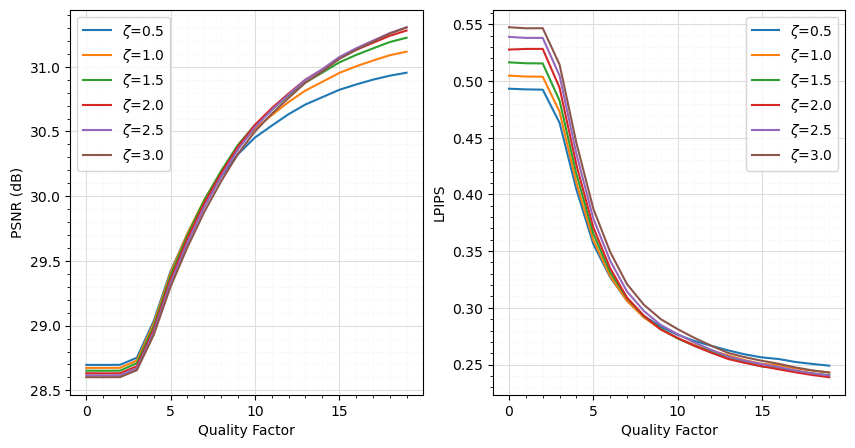

In [31]:
zeta_range = range(5,35,5)
qf_range = range(0,20)
fig, axs = plt.subplots(1,2, figsize=[10,5])

for i,z in enumerate(zeta_range):
    z_key = str(z)
    bpp = results_zoom[z_key]['bpp']
    psnr = results_zoom[z_key]['psnr']
    lpips_ = results_zoom[z_key]['lpips']
    axs[0].plot(qf_range,psnr,label=f'$\zeta$={z/10}')
    axs[1].plot(qf_range,lpips_,label=f'$\zeta$={z/10}')
    
axs[0].set_xlabel('Quality Factor')
axs[0].set_ylabel('PSNR (dB)')
axs[0].legend()
axs[1].set_xlabel('Quality Factor')
axs[1].set_ylabel('LPIPS')
axs[1].legend()

for i in range(2):
    axs[i].grid(which='major', color='#DDDDDD', linewidth=0.8)
    axs[i].minorticks_on()
    axs[i].grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

fig.show()

In [32]:
fig.savefig('figures/zoom_zeta_rd.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


**PSNR**: $\zeta$=0.5 achieves the best results for highly degraded images. Images processed with low quality factors have stronger blocking artefacts and colour banding, so better results can be achieved by light steering of the diffusion model, allowing it to alter the jpeg compressed image more. When the quality factor is above 8, higher values of $\zeta$ perform better, with $\zeta$=2.5 upper bounding all other curves. At higher quality factors, blocking artefacts are less significant so better results are obtained with heavier guidance from the INN, placing more emphasis on retaining information from the jpeg compressed input.

**LPIPS**: LPIPS displays similar trends. $\zeta$=0.5 has the best performance on the low-end of quality factor and then becomes the worst performing on the high-end. However, LPIPS conveys that the best-performing setting for higher quality factors is actually $\zeta$=2.0.

## Save Results

In [15]:
# store results

print(json.dumps(results, indent=4))

with open('results/rd_performance.json', 'w') as f:
    json.dump(results, f)

{
    "0": {
        "desc": "Scheme 0: JPEG ENC => JPEG DEC",
        "lpips": [
            0.6226144352555275,
            0.33526174813508985,
            0.19076370283961297,
            0.13424982622265816,
            0.10554397631436586,
            0.08652242634445428,
            0.07055502854287625,
            0.05244907151907682,
            0.033260732544586065,
            0.013870990304276347
        ],
        "psnr": [
            28.929796636797096,
            31.29620353454879,
            32.963303186457985,
            33.81205479513795,
            34.352502087660774,
            34.77655209498177,
            35.172445318996736,
            35.72118207713154,
            36.55123096023724,
            38.35282321870881
        ],
        "bpp": [
            0.16686798095703126,
            0.265042724609375,
            0.38778472900390626,
            0.49850311279296877,
            0.595843505859375,
            0.6916702270507813,
            0.79745666503

## Qualitative Results

Comparing jpeg vs regular vs down. Use best zeta setting for that scale. Compare the results of the function

In [50]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

['0.514bpp', '0.338bpp', '0.100bpp', 'N/A']
['0.353bpp', '0.245bpp', '0.079bpp', 'N/A']
['0.311bpp', '0.226bpp', '0.074bpp', 'N/A']


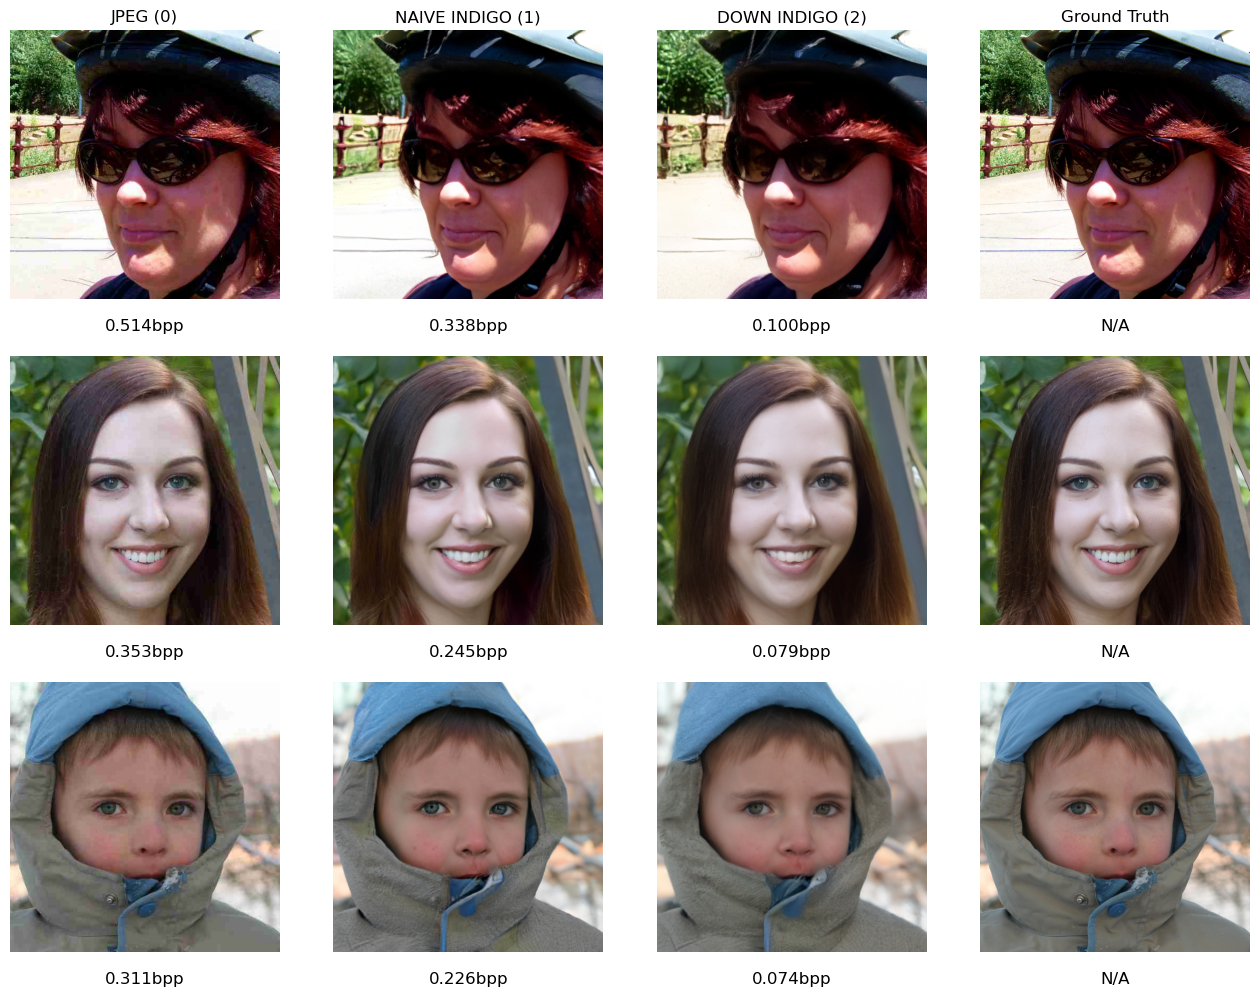

In [87]:
with open('results/rd_performance.json', 'r') as f:
    encsizes = json.load(f)

file_client = FileClient('disk')

dataset_opt = {
    'name': 'FFHQJPEGTest',
    'type': 'FFHQJPEGDataset',
    'phase': 'test',
    'gt_size': 512,
    'scale': 1,
    'encsize': True,
    'qf': 20,
    'dataroot_gt': 'datasets/ffhq/test',
    'io_backend':
        {'type': 'disk'} 
}
test_set = build_dataset(dataset_opt)
idxs = [0,37,56]
res_dir = 'results/jpeg_pipeline'
test_dir = 'testdata'
tests = ['jpeg_qf10','down_jpeg_qf40']
exps = ['default_large/jpeg_qf10', 'down_large_zeta10/jpeg_qf40']
labels = ['JPEG (0)', 'NAIVE INDIGO (1)', 'DOWN INDIGO (2)', 'Ground Truth']

# Retrieve encoding size
encsizes = []
for test in tests:
    enc_path = os.path.join(test_dir,test,f'encsizes.json')
    with open(enc_path, 'r') as f:
        encsizes.append(json.load(f))

# lq, reg, down, gt
fig, axs = plt.subplots(3,4, figsize=(16, 12))

for j in range(4):
    axs[0,j].set_title(labels[j], fontsize=12)

for i,idx in enumerate(idxs):
    imgs = []
    bpp = []
    data = test_set[idx]
    img_name = os.path.splitext(os.path.basename(data['gt_path']))[0]
    
    img_gt, img_lq = tensor2img([data['gt'], data['lq']],rgb2bgr=False)
    imgs.append(img_lq)
    tmp_bpp = calculate_bpp((512,)*2, encsize=data['encsize'].item())
    bpp.append(f'{tmp_bpp:.3f}bpp')
    
    for j,exp in enumerate(exps):
        res_path = os.path.join(res_dir,exp,f'restored_faces/{img_name}.png')
        img_bytes = file_client.get(res_path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
        img_res = cv2.cvtColor(img_res, cv2.COLOR_RGB2BGR)
        imgs.append(img_res)
        tmp_bpp = calculate_bpp((512,)*2, encsize = encsizes[j][img_name])
        bpp.append(f'{tmp_bpp:.3f}bpp')

    imgs.append(img_gt)
    bpp.append('N/A')

    print(bpp)

    for j,img in enumerate(imgs):
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        axs[i,j].text(0.5, -0.1, bpp[j], va='center', ha='center',
            rotation='horizontal', fontsize=12, transform=axs[i,j].transAxes)

fig.savefig('figures/same_psnr_qual_results.png', dpi=200, bbox_inches='tight')

Results with same bpp

['0.181bpp (minimum)', '0.086bpp', '0.086bpp', 'N/A']
['0.162bpp (minimum)', '0.068bpp', '0.068bpp', 'N/A']
['0.162bpp (minimum)', '0.068bpp', '0.068bpp', 'N/A']


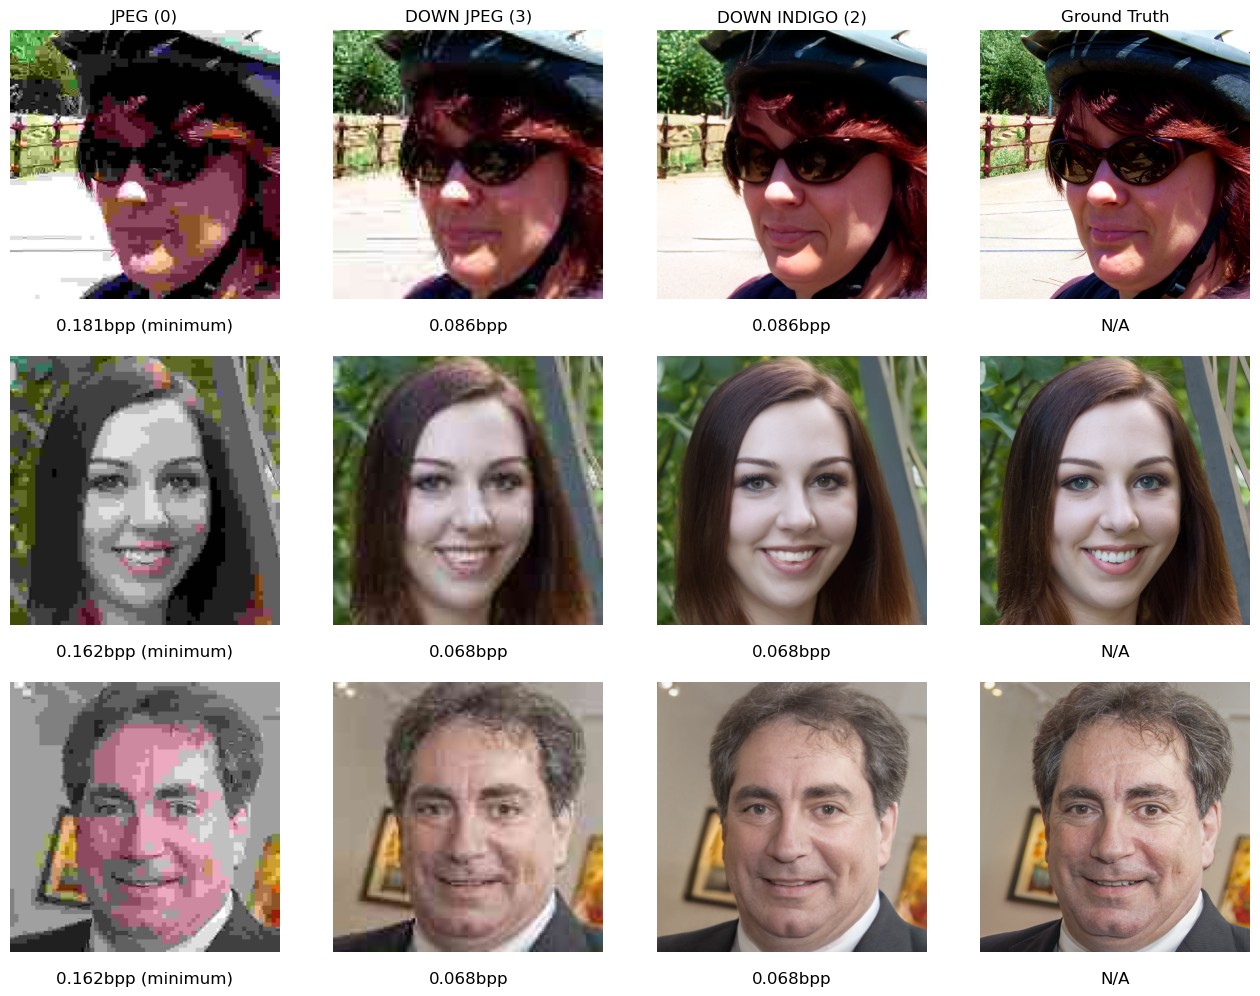

In [84]:
with open('results/rd_performance.json', 'r') as f:
    encsizes = json.load(f)

file_client = FileClient('disk')

dataset_opt = {
    'name': 'FFHQJPEGTest',
    'type': 'FFHQJPEGDataset',
    'phase': 'test',
    'gt_size': 512,
    'scale': 4,
    'encsize': True,
    'qf': 30,
    'dataroot_gt': 'datasets/ffhq/test',
    'io_backend':
        {'type': 'disk'} 
}

idxs = [0,37,2]
res_dir = 'results/jpeg_pipeline'
test_dir = 'testdata'
tests = ['down_jpeg_qf30']
exps = ['down_large_zeta10/jpeg_qf30']
labels = ['JPEG (0)', 'DOWN JPEG (3)', 'DOWN INDIGO (2)', 'Ground Truth']

# Retrieve encoding size
encsizes = []
for test in tests:
    enc_path = os.path.join(test_dir,test,f'encsizes.json')
    with open(enc_path, 'r') as f:
        encsizes.append(json.load(f))

# lq, reg, down, gt
fig, axs = plt.subplots(3,4, figsize=(16, 12))

for j in range(4):
    axs[0,j].set_title(labels[j], fontsize=12)

for i,idx in enumerate(idxs):
    imgs = []
    bpp = []
    data = test_set[idx]
    img_name = os.path.splitext(os.path.basename(data['gt_path']))[0]

    dataset_opt['scale'] = 1
    dataset_opt['qf'] = 0
    test_set = build_dataset(dataset_opt)
    data = test_set[idx]
    img_gt, img_lq = tensor2img([data['gt'], data['lq']],rgb2bgr=False)
    imgs.append(img_lq)
    tmp_bpp = calculate_bpp((512,)*2, encsize=data['encsize'].item())
    bpp.append(f'{tmp_bpp:.3f}bpp (minimum)')

    dataset_opt['scale'] = 4
    dataset_opt['qf'] = 30
    test_set = build_dataset(dataset_opt)
    data = test_set[idx]
    img_lq = tensor2img(data['lq'],rgb2bgr=False)[0]
    imgs.append(img_lq)
    tmp_bpp = calculate_bpp((512,)*2, encsize=data['encsize'].item())
    bpp.append(f'{tmp_bpp:.3f}bpp')
    
    for j,exp in enumerate(exps):
        res_path = os.path.join(res_dir,exp,f'restored_faces/{img_name}.png')
        img_bytes = file_client.get(res_path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
        img_res = cv2.cvtColor(img_res, cv2.COLOR_RGB2BGR)
        imgs.append(img_res)
        tmp_bpp = calculate_bpp((512,)*2, encsize = encsizes[j][img_name])
        bpp.append(f'{tmp_bpp:.3f}bpp')

    imgs.append(img_gt)
    bpp.append('N/A')

    print(bpp)

    for j,img in enumerate(imgs):
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        axs[i,j].text(0.5, -0.1, bpp[j], va='center', ha='center',
            rotation='horizontal', fontsize=12, transform=axs[i,j].transAxes)

fig.savefig('figures/same_bpp_qual_results.png', dpi=200, bbox_inches='tight')